In [1]:
import argparse
import inspect
import json
import logging
import random
import time
from copy import deepcopy
from dataclasses import dataclass, field
from datetime import datetime, timedelta, timezone
from functools import partial
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from pathos.multiprocessing import ProcessingPool as Pool
from sbi.inference import NPE, SNPE, DirectPosterior
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from simglucose.actuator.pump import InsulinPump
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj
from torch.distributions import Distribution
from tqdm import tqdm

from glucose_sbi.infer_parameters import get_patient_params
from glucose_sbi.prepare_priors import (
    InferredParams,
    Prior,
    construct_box_uniform_prior,
    prepare_prior,
)
from sbi.utils import RestrictedPrior, get_density_thresholder

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import jupyter_black

%load_ext jupyter_black

jupyter_black.load(line_length=88)

In [3]:
@dataclass
class DeafultSimulationEnv:
    """Dataclass for the default simulation environment."""

    patient_name: str
    sensor_name: str
    pump_name: str
    scenario: list[tuple[int, int]] = field(default_factory=list)
    hours: int = 24  # hours to simulate

In [4]:
def set_up_logging(saving_path: Path) -> logging.Logger:
    """Set up the logging configuration for the script."""
    logger = logging.getLogger("sbi_logger")
    logger.setLevel(logging.INFO)
    handler = logging.FileHandler(Path(saving_path, "inference_execution.log"))
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
default_meal_7 = 45
default_meal_12 = 70
default_meal_16 = 15
default_meal_18 = 80
default_meal_23 = 10
default_scenario = [
    (7, default_meal_7),
    (12, default_meal_12),
    (16, default_meal_16),
    (18, default_meal_18),
    (23, default_meal_23),
]

In [7]:
script_logger = set_up_logging(Path("meals_logs"))

In [8]:
total_carbs = sum([meal[1] for meal in default_scenario])
min_meal = min([meal[1] for meal in default_scenario])
max_meal = max([meal[1] for meal in default_scenario])

print(f"Total carbs: {total_carbs}")
print(f"Min meal: {min_meal}")
print(f"Max meal: {max_meal}")

Total carbs: 220
Min meal: 10
Max meal: 80


In [9]:
def _random_scenario() -> list[tuple[int, int]]:
    """Generate a random scenario."""
    return [
        (7, random.randint(1, 100)),
        (12, random.randint(1, 100)),
        (16, random.randint(1, 100)),
        (18, random.randint(1, 100)),
        (23, random.randint(1, 100)),
    ]

In [10]:
patient_name = "adolescent#002"
sensor_name = "Dexcom"
pump_name = "Insulet"

In [11]:
def load_default_simulation_env(
    env_settings: DeafultSimulationEnv, hours: int = 24
) -> T1DSimEnv:
    """Load the default simulation environment.

    Parameters
    ----------
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    hours : int, optional
        The number of hours to simulate, by default 24

    Returns
    -------
    T1DSimEnv
        The simulation environment object.

    """
    now = datetime.now(tz=timezone.utc)
    start_time = datetime.combine(now.date(), datetime.min.time())

    patient = T1DPatient.withName(env_settings.patient_name)
    sensor = CGMSensor.withName(env_settings.sensor_name, seed=1)
    pump = InsulinPump.withName(env_settings.pump_name)
    scenario = CustomScenario(start_time=start_time, scenario=env_settings.scenario)
    controller = BBController()
    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=scenario)

    return SimObj(
        env=env, controller=controller, sim_time=timedelta(hours=hours), animate=False
    )

In [12]:
def get_true_observation(
    prior: Prior, env_settings: DeafultSimulationEnv, hours: int = 24
) -> tuple[torch.Tensor, dict]:
    """Returns the single glucose dynamcis simulation from the default simulation environment parameters and these parameters.

    Parameters
    ----------
    prior : Prior
        DataClass object containing the priors for the parameters
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    hours : int, optional
        Duration of the simulation, by default 24

    Returns
    -------
    np.ndarray
        Time series of glucose dynamics.

    """
    default_simulation_env = load_default_simulation_env(
        env_settings=env_settings, hours=hours
    )
    default_simulation_env.simulate()
    # true_params = get_patient_params(default_simulation_env, prior)
    true_observation = default_simulation_env.results()["CGM"].to_numpy()
    true_observation = torch.from_numpy(true_observation).float().to(device)
    return true_observation  # , true_params

In [13]:
def run_glucose_simulator(
    theta: torch.Tensor,
    default_settings: DeafultSimulationEnv,
    inferred_params: InferredParams,
    hours: int = 24,
    *,
    device: torch.device,
    infer_meal_params: bool = False,
    logger: logging.Logger | None = None,
) -> torch.Tensor:
    """Run the glucose simulator for a batch of custom parameters.

    Parameters
    ----------
    theta : torch.Tensor
        Sets of custom parameters to use for the simulation of shape (N_sets, N_params)
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    inferred_params : InferredParams
        DataClass object containing the names of inferred parameters
    hours : int, optional
        Duration of the simulation, by default 24
    device : torch.device, optional
        Device used to store the results, by default torch.device("cpu")
    logger : logging.Logger, optional
        The logger object, by default None
    infer_meal_params : bool, optional
        Whether to infer meal parameters, by default False

    Returns
    -------
    torch.Tensor
        The glucose dynamics time series for each simulation

    """
    if logger:
        logger.info("Running the glucose simulator on theta of shape, %s", theta.shape)
    simulation_envs = create_simulation_envs_with_custom_params(
        theta=theta,
        default_settings=default_settings,
        inferred_params=inferred_params,
        infer_meal_params=infer_meal_params,
        hours=hours,
    )
    return simulate_batch(simulation_envs, device, logger)


def simulate_batch(
    simulations: list[T1DSimEnv],
    device: torch.device,
    logger: logging.Logger | None = None,
) -> torch.Tensor:
    """Simulate a batch of simulation environments in parallel.

    Parameters
    ----------
    simulations : list[T1DSimEnv]
        List of simulation environments
    device : torch.device
        The device to store the results on, by default torch.device("cpu")
    logger : logging.Logger, optional
        The logger object, by default None

    Returns
    -------
    torch.Tensor
        The glucose dynamics for each simulation

    """
    pathos = True
    tic = time.time()
    if pathos:
        if logger:
            logger.info("Using pathos for parallel processing")
        with Pool() as p:
            results = p.map(simulate_glucose_dynamics, simulations)
    else:
        results = [simulate_glucose_dynamics(s) for s in tqdm(simulations)]
    results = np.stack(results)
    toc = time.time()
    if logger:
        # log in seconds
        logger.info("Simulation took %s seconds", toc - tic)
    return torch.from_numpy(results).float().to(device)


def simulate_glucose_dynamics(simulation_env: T1DSimEnv) -> np.ndarray:
    """Simulates the glucose dynamics for a given simulation environment.

    Parameters
    ----------
    simulation_env : T1DSimEnv
        The simulation environment object

    Returns
    -------
    np.ndarray
        The glucose dynamics

    """
    simulation_env.simulate()
    return simulation_env.results()["CGM"].to_numpy()


def create_simulation_envs_with_custom_params(
    theta: torch.Tensor,
    default_settings: DeafultSimulationEnv,
    inferred_params: InferredParams,
    hours: int = 24,
    *,
    infer_meal_params: bool = False,
) -> list[T1DSimEnv]:
    """Creates a list of simulation environments with custom parameters.

    Parameters
    ----------
    theta : torch.Tensor
        Sets of custom parameters to use for the simulation of shape (N_sets, N_params)
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    inferred_params : InferredParams
        DataClass object containing the names of inferred parameters
    hours : int, optional
        Duration of simulation, by default 24
    infer_meal_params : bool, optional
        Whether to infer meal parameters, by default False

    Returns
    -------
    list[T1DSimEnv]
        List of simulation environments with custom parameters

    """
    default_simulation_env = load_default_simulation_env(
        hours=hours, env_settings=default_settings
    )
    simulation_envs = []
    for _, theta_i in enumerate(theta):
        custom_sim_env = deepcopy(default_simulation_env)

        set_custom_params(
            custom_sim_env,
            theta_i,
            inferred_params,
            infer_meal_params=infer_meal_params,
        )
        simulation_envs.append(custom_sim_env)

    return simulation_envs


def set_custom_params(
    default_simulation_env: DeafultSimulationEnv,
    theta: torch.Tensor,
    inferred_params: InferredParams,
    *,
    infer_meal_params: bool = False,
) -> None:
    """Apply the custom parameters (used for a particular simulation) for the patient.

    Parameters
    ----------
    default_simulation_env : DefaultSimulationEnv
        The simulation environment containing the patient and scenario.
    theta : torch.Tensor
        One set of custom parameters to apply to the patient.
    inferred_params : InferredParams
        DataClass object containing the names of inferred parameters.
    infer_meal_params : bool, optional
        Whether to infer meal parameters, by default False

    """
    theta_list = theta.clone().tolist()
    param_names = inferred_params.params_names
    patient = default_simulation_env.env.patient

    # Separate meal and non-meal parameters
    meal_indices, meal_values, other_params, other_values = _separate_parameters(
        param_names, theta_list
    )

    if infer_meal_params and meal_indices:
        # Update meal parameters in the scenario
        _update_meal_parameters(
            default_simulation_env.env.scenario.scenario, meal_values
        )

    # Update other parameters in the patient
    _update_patient_parameters(patient, other_params, other_values)


def _separate_parameters(
    param_names: list[str], theta_list: list[float]
) -> tuple[list[int], list[float], list[str], list[float]]:
    """Separate meal and non-meal parameters."""
    meal_indices = [i for i, param in enumerate(param_names) if "meal" in param]
    meal_values = [theta_list[i] for i in meal_indices]

    non_meal_indices_and_params = [
        (i, param) for i, param in enumerate(param_names) if "meal" not in param
    ]
    other_params = [param for _, param in non_meal_indices_and_params]
    other_values = [theta_list[i] for i, _ in non_meal_indices_and_params]

    return meal_indices, meal_values, other_params, other_values


def _update_meal_parameters(
    scenario: list[tuple[str, float]], meal_values: list[float]
) -> None:
    """Update meal parameters in the scenario."""
    for i, (meal_name, _) in enumerate(scenario):
        scenario[i] = (meal_name, meal_values[i])


def _update_patient_parameters(
    patient: T1DPatient, params: list[str], values: list[float]
) -> None:
    """Update non-meal parameters in the patient."""
    for param, value in zip(params, values):
        setattr(patient._params, param, value)  # noqa: SLF001

In [14]:
def _check_prior_for_meals(prior: Prior) -> bool:
    """Check if the prior contains meal parameters."""
    return any("meal" in param for param in prior.params_names)


def set_up_sbi_simulator(
    prior: Prior,
    default_settings: DeafultSimulationEnv,
    glucose_simulator: Callable[..., torch.Tensor],
    *,
    device: torch.device,
    infer_meal_params: bool = False,
) -> Callable:
    """Sets up and checks the simulator for the Sequential Bayesian Inference (SBI) framework.

    Parameters
    ----------
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    prior : Prior
        DataClass object containing the priors for the parameters
    device : torch.device
        Device used to run the simulation
    glucose_simulator : callable, optional
        Function that runs the glucose simulator, by default run_glucose_simulator
    processed_priors : Distribution, optional
        Processed priors for the parameters, by default None
    infer_meal_params : bool, optional
        Whether to infer meal parameters, by default False

    Returns
    -------
    callable
        The SBI simulator function used to infer the parameters

    """
    if infer_meal_params and not _check_prior_for_meals(prior):
        script_logger.warning(
            "The prior distribution is missing meal parameters despite infer_meal_params being True"
        )

    processed_priors, _, _ = process_prior(prior.params_prior_distribution)
    script_logger.info(
        "Using prior distribution of shape: %s", processed_priors.event_shape
    )
    wrapper = partial(
        glucose_simulator,
        default_settings=default_settings,
        inferred_params=prior,
        device=device,
        logger=script_logger,
        infer_meal_params=infer_meal_params,
    )

    sbi_simulator = process_simulator(
        wrapper, processed_priors, is_numpy_simulator=True
    )

    check_sbi_inputs(sbi_simulator, processed_priors)

    return sbi_simulator

In [15]:
def sample_positive(
    distribution: Distribution | DirectPosterior,
    num_samples: int,
    x_true: torch.Tensor | None = None,
    batch_size: int | None = None,  # Adjustable batch size for efficiency
) -> torch.Tensor:
    """Samples positive values from a distribution using batch processing.

    Parameters
    ----------
    distribution : Distribution | DirectPosterior
        The distribution to sample from.
    num_samples : int
        The number of positive samples to generate.
    x_true : torch.Tensor, optional
        The conditioning observation, if applicable.
    batch_size : int, optional
        The number of samples to draw in each batch to improve efficiency.

    Returns
    -------
    torch.Tensor
        The tensor of positive samples of shape (num_samples, num_params).

    """
    if not batch_size:
        batch_size = num_samples // 10

    collected = []
    # Determine if x should be passed
    sample_params = inspect.signature(distribution.sample).parameters
    kwargs = {"x": x_true} if "x" in sample_params else {}

    total_collected = 0.0
    last_logged_pct = 0.0

    while total_collected < num_samples:
        # Sample in batches
        batch_samples = distribution.sample((batch_size,), **kwargs)

        # Vectorized filtering of positive samples
        positive_samples = batch_samples[torch.all(batch_samples > 0, dim=1)]

        collected.append(positive_samples)
        total_collected = sum(t.shape[0] for t in collected)

        # Compute progress percentage
        pct_complete = min(total_collected / num_samples * 100, 100)

        # Log only if at least 10% more progress is made
        milestone = 10.0
        if pct_complete - last_logged_pct >= milestone:
            script_logger.info("Collected %.2f%% of positive samples", pct_complete)
            last_logged_pct = pct_complete  # Update last logged percentage

    # Concatenate and return exactly num_samples
    return torch.cat(collected, dim=0)[:num_samples]

In [16]:
def bayes_flow(
    prior: Distribution, simulator: Callable, num_sims: int
) -> DirectPosterior:
    """Run the BayesFlow algorithm (single round of NPE).

    Parameters
    ----------
    prior : Distribution
        The prior distribution for the parameters to infer.
    simulator : Callable
        The simulator function that generates the data.
    num_sims : int
        The number of simulations to run.

    Returns
    -------
    DirectPosterior
        The posterior distribution of the parameters.

    """
    script_logger.info(
        "Running BayesFlow inference on prior of shape: %s", prior.event_shape
    )
    inference = NPE(prior=prior, device=device)
    theta = sample_positive(prior, num_sims)
    x = simulator(theta)
    theta = theta.to(device)
    x = x.to(device)
    inference.append_simulations(theta, x).train()
    return inference.build_posterior()

In [17]:
def tsnpe(
    prior: Distribution,
    simulator: Callable,
    true_observation: torch.Tensor,
    device: torch.device,
    sample_proposal_with: str = "rejection",
    num_rounds: int = 10,
    num_simulations: int = 1000,
) -> DirectPosterior:
    """Runs the Truncated Sequential Neural Posterior Estimation (TSNPE) algorithm.

    Parameters
    ----------
    prior : Distribution
        The prior distribution for the parameters to infer.
    simulator : callable
        The simulator function that generates the data.
    true_observation : torch.Tensor
        The true observation to compare the inference results to.
    device : torch.device
        The device to use for the simulation.
    sampling_method : str
        The sampling method to use in `build_posterior` method.
    sample_proposal_with : str, optional
        The sampling method to sample from the proposal distribution, by default "rejection"
    num_rounds : int, optional
        number  of inference rounds, by default 10
    num_simulations : int, optional
        number of simulations per inferenceround, by default 1000

    Returns
    -------
    Posterior
        The posterior distribution of the parameters.

    """
    inference = SNPE(prior=prior, device=device)
    proposal = prior
    for r in range(num_rounds):

        theta = sample_positive(proposal, num_simulations)
        script_logger.info("Simulating theta of shape: %s", theta.shape)
        x = simulator(theta)
        # Optional sanity check: ensure on same device
        theta = theta.to(device)
        x = x.to(device)

        _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
        posterior = inference.build_posterior(sample_with="direct").set_default_x(
            true_observation
        )

        accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
        proposal = RestrictedPrior(
            prior,
            accept_reject_fn,
            sample_with=sample_proposal_with,
            device=device,
            posterior=posterior if sample_proposal_with == "sir" else None,
        )

    return posterior

In [18]:
def_env = DeafultSimulationEnv(
    patient_name=patient_name,
    sensor_name=sensor_name,
    pump_name=pump_name,
    scenario=_random_scenario(),
    hours=24,
)
true_meals = def_env.scenario
print("True_meals: ", true_meals)

True_meals:  [(7, 27), (12, 99), (16, 40), (18, 93), (23, 80)]


In [19]:
prior = prepare_prior(
    script_dir=Path("glucose_sbi"),
    data_file="params_trung.json",
    prior_type="uniform",
    number_of_params=10,
    inflation_factor=1.0,
    mean_shift=0,
    device=device,
    infer_meal_params=True,
)

INFO:sbi_logger:Constructing BoxUniform prior...


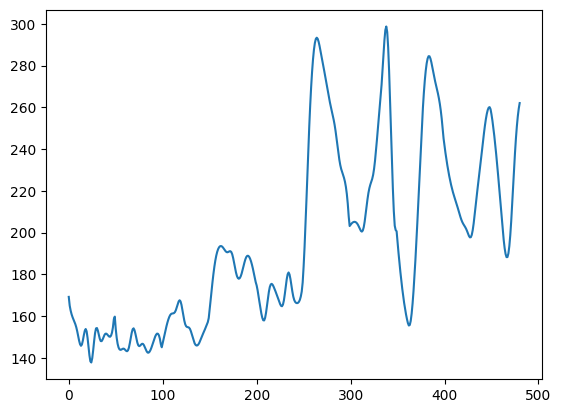

In [20]:
true_observation = get_true_observation(prior, def_env)
true_observation_array = true_observation.cpu().numpy()
plt.plot(true_observation_array)

In [21]:
print(prior.params_names)

['m1', 'ki', 'kp1', 'kd', 'd', 'ka2', 'kabs', 'Vmx', 'm2', 'ksc', 'meal_0', 'meal_1', 'meal_2', 'meal_3', 'meal_4']


In [22]:
sbi_simulator = set_up_sbi_simulator(
    prior=prior,
    default_settings=def_env,
    device=device,
    glucose_simulator=run_glucose_simulator,
    infer_meal_params=True,
)

INFO:sbi_logger:Using prior distribution of shape: torch.Size([15])
INFO:sbi_logger:Running the glucose simulator on theta of shape, torch.Size([2, 15])
INFO:sbi_logger:Using pathos for parallel processing
INFO:sbi_logger:Simulation took 7.526661157608032 seconds
INFO:sbi_logger:Running the glucose simulator on theta of shape, torch.Size([1, 15])
INFO:sbi_logger:Using pathos for parallel processing
INFO:sbi_logger:Simulation took 6.35505223274231 seconds


In [23]:
posterior = tsnpe(
    prior=prior.params_prior_distribution,
    simulator=sbi_simulator,
    num_simulations=500,
    num_rounds=3,
    sample_proposal_with="sir",
    device=device,
    true_observation=true_observation,
)

INFO:sbi_logger:Collected 10.00% of positive samples
INFO:sbi_logger:Collected 20.00% of positive samples
INFO:sbi_logger:Collected 30.00% of positive samples
INFO:sbi_logger:Collected 40.00% of positive samples
INFO:sbi_logger:Collected 50.00% of positive samples
INFO:sbi_logger:Collected 60.00% of positive samples
INFO:sbi_logger:Collected 70.00% of positive samples
INFO:sbi_logger:Collected 80.00% of positive samples
INFO:sbi_logger:Collected 90.00% of positive samples
INFO:sbi_logger:Collected 100.00% of positive samples
INFO:sbi_logger:Simulating theta of shape: torch.Size([500, 15])
INFO:sbi_logger:Running the glucose simulator on theta of shape, torch.Size([500, 15])
INFO:sbi_logger:Using pathos for parallel processing
INFO:sbi_logger:Simulation took 380.0406708717346 seconds
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed 

 Neural network successfully converged after 134 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 10.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 20.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 30.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 40.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 50.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 60.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 70.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 80.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 90.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 100.00% of positive samples
INFO:sbi_logger:Simulating theta of shape: torch.Size([500, 15])
INFO:sbi_logger:Running the glucose simulator on theta of shape, torch.Size([500, 15])
INFO:sbi_logger:Using pathos for parallel processing
INFO:sbi_logger:Simulation took 387.5962038040161 seconds
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 99 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 10.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 20.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 30.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 40.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 50.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 60.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 70.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 80.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 90.00% of positive samples


Drawing 1600 posterior samples:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:sbi_logger:Collected 100.00% of positive samples
INFO:sbi_logger:Simulating theta of shape: torch.Size([500, 15])
INFO:sbi_logger:Running the glucose simulator on theta of shape, torch.Size([500, 15])
INFO:sbi_logger:Using pathos for parallel processing
INFO:sbi_logger:Simulation took 385.8660068511963 seconds
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
c:\Users\bythe\Desktop\Glucose Project\.venv\Lib\site-packages\sbi\inference\trainers\npe\npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 95 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [24]:
samples = posterior.sample((100,), x=true_observation)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

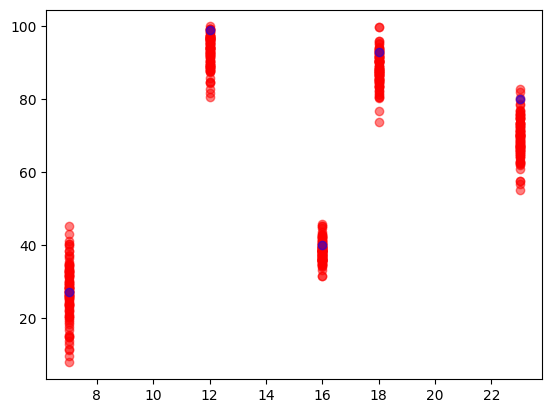

In [25]:
meal_times = [7, 12, 16, 18, 23]
true_meals = [meal[1] for meal in true_meals]
for i, sample in enumerate(samples):
    plt.scatter(meal_times, sample[-5:].cpu().numpy(), c="r", alpha=0.5)
plt.scatter(meal_times, true_meals, c="b", alpha=0.5)

In [26]:
sim = run_glucose_simulator(
    samples,
    def_env,
    inferred_params=InferredParams(prior.params_names),
    device=device,
    infer_meal_params=True,
)

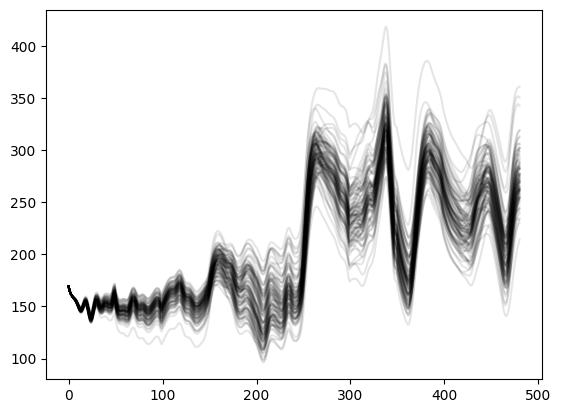

In [27]:
sim_array = sim.cpu().numpy()
plt.plot(sim_array.T, alpha=0.1, c="black")

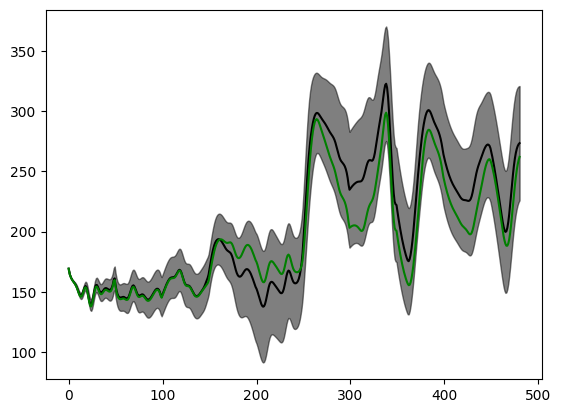

In [28]:
sim_array = sim.cpu().numpy()
mean_sim = np.mean(sim_array, axis=0)
std_sim = np.std(sim_array, axis=0)
plt.plot(np.mean(sim_array, axis=0), label="Mean simulation", color="black")
plt.fill_between(
    range(481), mean_sim - 2 * std_sim, mean_sim + 2 * std_sim, color="black", alpha=0.5
)

plt.plot(true_observation_array, label="True observation", color="green")